# Промышленность

## Описание и цель проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

Цель нашего проекта: построить модель, которая будет предсказывать темперауру сплава. 

In [1]:
!pip install --upgrade scikit-learn -q
!pip install shap  -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap #, phik

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool
from scipy.stats import spearmanr

RANDOM_STATE = 30625
TEST_SIZE = 0.25

In [2]:
plt.rcParams["figure.figsize"] = (10,5)
pd.set_option('display.max_columns', None)  # Отображать все столбцы

## Загрузка данных

Данные состоят из нескольких файлов, полученных из разных источников:
 - data_arc_new.csv — данные об электродах;
 - data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
 - data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
 - data_gas_new.csv — данные о продувке сплава газом;
 - data_temp_new.csv — результаты измерения температуры;
 - data_wire_new.csv — данные о проволочных материалах (объём);
 - data_wire_time_new.csv — данные о проволочных материалах (время).
 
Загрузим данные и выполним их первичный осмотр.

Так как действие будет повторяться, напишем функцию для чтения файла и вывода основной информации.

In [3]:
def load_csv_as_dataframe(file_path):    
    try:
        df = pd.read_csv(file_path)  # попытка чтения файла
        display(df.head()) # вывод первых пяти строк
        print(df.info()) # вывод общей информации о DataFrame
        return df
    except FileNotFoundError:
        print(f"Ошибка: Файл {file_path} не найден.")
    except pd.errors.EmptyDataError:
        print(f"Ошибка: Файл {file_path} пуст.")
    except pd.errors.ParserError:
        print(f"Ошибка: Ошибка парсинга CSV файла {file_path}.")
    except Exception as e:
        print(f"Произошла непредвиденная ошибка при чтении {file_path}: {e}")
    return None

### data_arc_new.csv — данные об электродах

In [4]:
data_arc_new = load_csv_as_dataframe('/datasets/data_arc_new.csv')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


Таблица с данными об электродах (data_arc_new.csv) не содержит пропусков. Тип данных начала и конца нагрева дугой логично изменить на datetime, но будем это делать при предобработке данных.

### data_bulk_new.csv — данные о подаче сыпучих материалов (объём)

In [5]:
data_bulk_new = load_csv_as_dataframe('/datasets/data_bulk_new.csv')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


Таблица с данными о подаче сыпучих материалов (объём) (data_bulk_new.csv) содержит нулевые значения. Предположим, что пропуски можно заменить нулями, вероятно, сыпучие материалы просто не добавлялись в указанный момент времени. Все изменения данных будут выполнены в следующих шагах, сейчас мы только загружаем и проводим первичный осмотр данных.
Типы данных в таблице data_bulk_new указаны корректно.

### data_bulk_time_new.csv — данные о подаче сыпучих материалов (время)

In [6]:
data_bulk_time_new = load_csv_as_dataframe('/datasets/data_bulk_time_new.csv')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


Таблица с данными о подаче сыпучих материалов (время) (data_bulk_time_new.csv) содержит нулевые значения. 
Аналогично предыдущей таблице, логично предположить, что сыпучие материалы просто не добавлялись в указанный момент времени. 
Все изменения данных будут выполнены в следующих шагах, сейчас мы только загружаем и проводим первичный осмотр данных.
Типы данных аналогично заменить на datetime.

### data_gas_new.csv — данные о продувке сплава газом

In [7]:
data_gas_new = load_csv_as_dataframe('/datasets/data_gas_new.csv')

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


Пустых значений в таблице с данными о продувке сплава газом (data_gas_new.csv) нет, формат данных верный.

### data_temp_new.csv — результаты измерения температуры

In [8]:
data_temp_new = load_csv_as_dataframe('/datasets/data_temp_new.csv')

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None


В таблице с результатами измерения температуры (data_temp_new.csv) есть пропуски в столбце "Температура" (заполнять их или удалять - решим на этапе исследовательского анализа данных).
Тип данных в столбце "Время замера" логично изменить на datetime.
Также можно заметить закономерность, что данные в столбце "Время замера" на 10 секунд меньше значения в столбце "Начало нагрева дугой" в таблице data_arc_new.csv.

###  data_wire_new.csv — данные о проволочных материалах (объём)

In [9]:
data_wire_new = load_csv_as_dataframe('/datasets/data_wire_new.csv')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


С данными о проволочных материалах (объём) (data_wire_new.csv) аналогично сыпучим материалам - пропуски можно заменить нулями.
Тип данных указан корректно.

### data_wire_time_new.csv — данные о проволочных материалах (время)

In [10]:
data_wire_time_new = load_csv_as_dataframe('/datasets/data_wire_time_new.csv')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


Таблица с данными о подаче проволочных материалов (время) (data_wire_time_new.csv) содержит нулевые значения. 
Логично предположить, что проволочные материалы просто не добавлялись в указанный момент времени. 
Все изменения данных будут выполнены в следующих шагах, сейчас мы только загружаем и проводим первичный осмотр данных.
Типы данных логично заменить на datetime.

### Промежуточный вывод

Данные загружены, встречаются пропуски, которые следует обработать на следующем этапе.
Также требуется откорректировать формат данных в некоторых таблицах, провести исследовательский анализ, на основании которого также будут выполнена обработка данных.

## Исследовательский анализ и предобработка данных

На данном этапе для каждой таблицы проведем исследовательский анализ и предобработку данных (проверим на наличие дубликатов, выявим и удалим аномалии, исправим тип данных, заполним пропуски, при необходимости сгенерируем новые признаки, выполним агрегирование по ключу).

### data_arc_new.csv — данные об электродах

In [11]:
print('Количество дубликатов:', data_arc_new.duplicated().sum())

Количество дубликатов: 0


Пустых значений в этой таблице тоже нет.
Заменим тип данных столбцов "Начало нагрева дугой" и "Конец нагрева дугой" на datetime.

In [12]:
date_columns = ['Начало нагрева дугой', 'Конец нагрева дугой']
data_arc_new[date_columns] = data_arc_new[date_columns].apply(pd.to_datetime)
data_arc_new.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Проанализируем данные в таблице на наличие аномальных значений. Построим графики для каждого количественные признака. Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

А также постоим "ящик с усами".

,count,mean,std,min,25%,50%,75%,max,IQR,box_min,box_max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000,1623.000000,-1628.500000,4863.500000
Активная мощность,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773,0.362955,-0.077318,1.374503
Реактивная мощность,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284,0.271026,-0.069364,1.014739


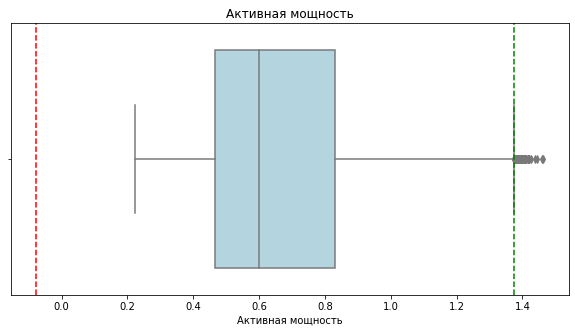

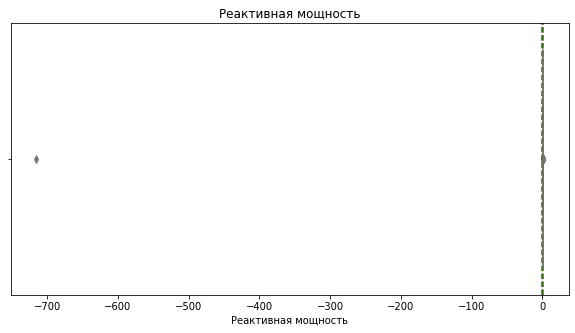

In [13]:
info_data_arc_new = data_arc_new.describe().T

info_data_arc_new['IQR'] = info_data_arc_new['75%'] - info_data_arc_new['25%']
info_data_arc_new['box_min'] = info_data_arc_new['25%'] - 1.5 * info_data_arc_new['IQR']
info_data_arc_new['box_max'] = info_data_arc_new['75%'] + 1.5 * info_data_arc_new['IQR']
display(info_data_arc_new)


cols = [col for col in data_arc_new.select_dtypes('number') if col != 'key']

for col in cols:
    sns.boxplot(x=data_arc_new[col], color='lightblue')
    plt.axvline(info_data_arc_new.loc[col, 'box_min'], color='red', ls='--')
    plt.axvline(info_data_arc_new.loc[col, 'box_max'], color='green', ls='--')
    plt.title(f'{col}')
    plt.show()

Видим аномально низкое значение реактивной мощности.
Выведем уникальные значения столбца 'Реактивная мощность' по возрастанию.

In [14]:
unique_values = sorted(data_arc_new['Реактивная мощность'].unique())
print('Значения столбца "Реактивная мощность":', unique_values[:3], '...', unique_values[-3:])


Значения столбца "Реактивная мощность": [-715.479924, 0.153777, 0.153921] ... [1.223063, 1.258628, 1.270284]


То есть у нас есть одно аномальное значение, остальные положительные (не превышающие допустимый максимум).


In [15]:
data_arc_new[(data_arc_new['Реактивная мощность'] < 0)]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Посчитаем корреляцию между активной и реактивной мощностью (и если она высокая, то заполним аномальное значение реактивной мощности на основе значения активной мощности).

In [17]:
# посчитаем корреляцию между активной и реактивной мощностью
x = data_arc_new['Активная мощность']
y = data_arc_new['Реактивная мощность']

# фильтруем строки: нет пропусков и реактивная мощность >= 0
mask = x.notna() & y.notna() & (y >= 0)

r_spearman, p_value = spearmanr(x[mask], y[mask])
print(f'Спирменовская корреляция: {r_spearman:.3f}, p-value: {p_value:.3g}')

Спирменовская корреляция: 0.971, p-value: 0


Корреляция высокая, можем заполнить значение реактивной мощности по значению активной.

In [18]:
# cтроим полиномиальную модель степени 2
coeffs = np.polyfit(x[mask], y[mask], deg=2)

# индексы с отрицательными значениями реактивной мощности
mask_neg = data_arc_new['Реактивная мощность'] < 0
x_neg = data_arc_new.loc[mask_neg, 'Активная мощность']

# заменяем отрицательные значения предсказанными
data_arc_new.loc[mask_neg, 'Реактивная мощность'] = (
    coeffs[0] * x_neg**2 + coeffs[1] * x_neg + coeffs[2]
)

In [19]:
data_arc_new[(data_arc_new['Реактивная мощность'] < 0)]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


In [20]:
data_arc_new[(data_arc_new['key'] == 2116)]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,0.517441
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Визуализируем данные.

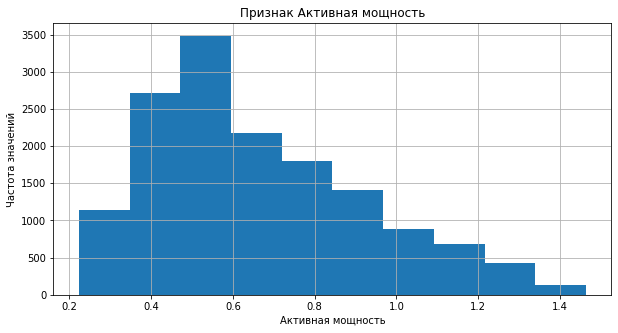

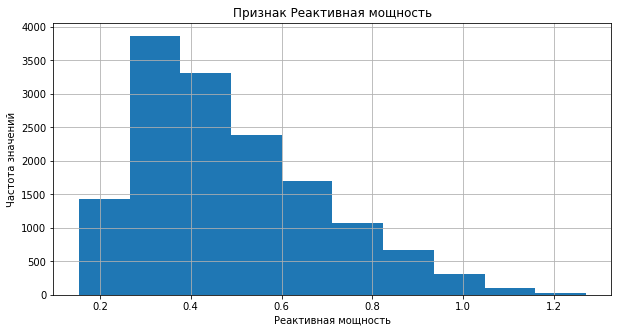

In [21]:
# определяем количественные признаки
numerical_features = ['Активная мощность', 'Реактивная мощность']

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(data_arc_new[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show()  

Чтобы оценить корректность дат начала и конца нагрева, предлагается найти максимальное и минимальное значение, а также визуализировать продолжительность нагрева (чтобы оценить, не греется ли у нас какой-то ковш больше референсных значений).

In [22]:
print('Минимальная дата начала нагрева:', data_arc_new['Начало нагрева дугой'].min())
print('Максимальная дата начала нагрева:', data_arc_new['Начало нагрева дугой'].max())
print('Минимальная дата конца нагрева:', data_arc_new['Конец нагрева дугой'].min())
print('Максимальная дата конца нагрева:', data_arc_new['Конец нагрева дугой'].max())

Минимальная дата начала нагрева: 2019-05-03 11:02:14
Максимальная дата начала нагрева: 2019-09-06 17:24:54
Минимальная дата конца нагрева: 2019-05-03 11:06:02
Максимальная дата конца нагрева: 2019-09-06 17:26:15


Все даты в промежутке с мая по сентябрь 2019 года, здесь всё корректно.

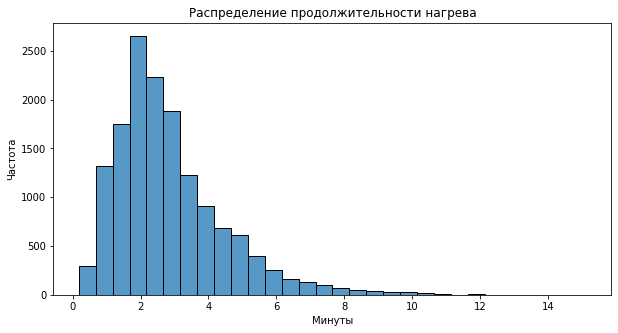

In [23]:
# Расчет и визуализация продолжительности нагрева
data_arc_new['Продолжительность нагрева (мин)'] = (
    data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']
).dt.total_seconds() / 60

sns.histplot(data_arc_new['Продолжительность нагрева (мин)'], bins=30)
plt.title('Распределение продолжительности нагрева')
plt.xlabel('Минуты')
plt.ylabel('Частота')
plt.show()

In [24]:
info_data_arc_new = data_arc_new.describe().T
info_data_arc_new['norm_min']=info_data_arc_new['25%']-1.5*info_data_arc_new['std']
info_data_arc_new['norm_max']=info_data_arc_new['75%']+1.5*info_data_arc_new['std']
info_data_arc_new

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000,-595.857253,3830.857253
Активная мощность,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773,0.078787,1.218398
Реактивная мощность,14876.0,0.487117,0.197606,0.153777,0.337192,0.441667,0.608201,1.270284,0.040783,0.904610
Продолжительность нагрева (мин),14876.0,2.861182,1.636447,0.183333,1.783333,2.450000,3.566667,15.116667,-0.671337,6.021337


Возможно, интервалы более 12 минут - не самые распространенные, но на аномальные не похожи, предлагается их оставить, как исключительные случаи нагрева.

Создадим новый параметр на основании активной и реактивной мощностей - комплексную мощность.
Для этого рассчитаем ее по формуле: 

S = sqrt(P^2 + Q^2)

In [25]:
data_arc_new['Полная мощность'] = np.sqrt(data_arc_new['Активная мощность']**2 + data_arc_new['Реактивная мощность']**2)
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   key                              14876 non-null  int64         
 1   Начало нагрева дугой             14876 non-null  datetime64[ns]
 2   Конец нагрева дугой              14876 non-null  datetime64[ns]
 3   Активная мощность                14876 non-null  float64       
 4   Реактивная мощность              14876 non-null  float64       
 5   Продолжительность нагрева (мин)  14876 non-null  float64       
 6   Полная мощность                  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 813.7 KB


In [26]:
data_arc_new_agg = data_arc_new.groupby('key').agg({'Начало нагрева дугой':'min', 'Полная мощность':'sum', 'Продолжительность нагрева (мин)':'sum'}).reset_index()


In [27]:
data_arc_new_agg

,key,Начало нагрева дугой,Полная мощность,Продолжительность нагрева (мин)
0,1,2019-05-03 11:02:14,3.718736,18.300000
1,2,2019-05-03 11:34:14,2.588349,13.516667
2,3,2019-05-03 12:06:54,5.019223,10.916667
3,4,2019-05-03 12:39:37,3.400038,12.350000
4,5,2019-05-03 13:11:13,2.816980,14.483333
...,...,...,...,...
3209,3237,2019-09-06 11:31:25,3.250657,15.150000
3210,3238,2019-09-06 12:16:25,1.723937,9.100000
3211,3239,2019-09-06 14:17:00,6.014480,20.266667
3212,3240,2019-09-06 15:25:31,4.082920,13.983333


Данные о начале нагрева пока сохраним, чтобы точно знать, что в итоговой таблице у нас будет первая температура сплава (она не может быть позже начала нагрева).
Данные о конце нагрева не потребуются нам для обучения модели.
Переходим к следующей таблице.

### data_bulk_new.csv — данные о подаче сыпучих материалов (объём)

In [28]:
print('Количество дубликатов:', data_bulk_new.duplicated().sum())

Количество дубликатов: 0


Проанализируем данные в таблице на наличие аномальных значений. Построим графики для каждого количественные признака. Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [29]:
info_data_bulk_new = data_bulk_new.describe().T
info_data_bulk_new['norm_min']=info_data_bulk_new['25%']-1.5*info_data_bulk_new['std']
info_data_bulk_new['norm_max']=info_data_bulk_new['75%']+1.5*info_data_bulk_new['std']
info_data_bulk_new

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0,-584.006464,3831.006464
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0,-0.416481,73.416481
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0,210.229133,289.520867
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0,-55.225241,265.225241
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0,-0.276189,205.276189
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0,-52.685970,254.685970
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0,-38.336664,265.086664
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0,-131.534357,692.534357
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0,NaN,NaN
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0,33.419129,103.080871


Максимальные/минимальные значения показателей где-то выше/ниже рассчитанных, но не будем считать их аномальными, это же примеси, их значения, действительно, могут быть настолько разнородными (хотя по графикам ниже тоже складывается впечатление аномальности).

Визуализируем данные.

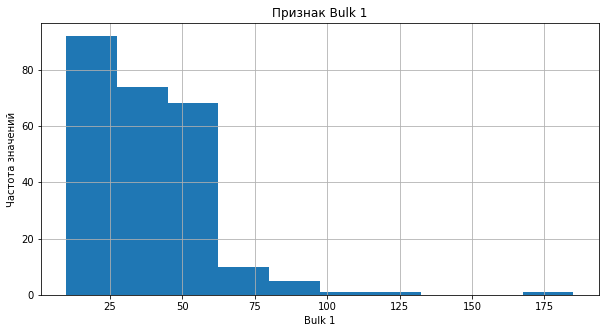

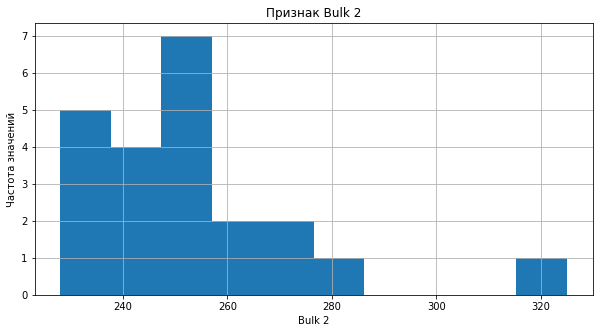

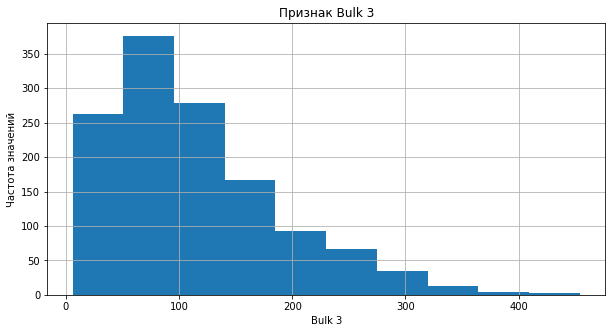

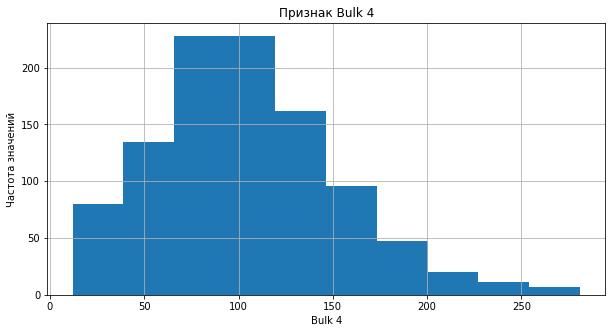

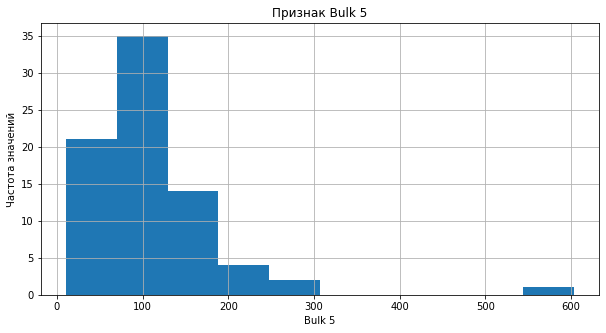

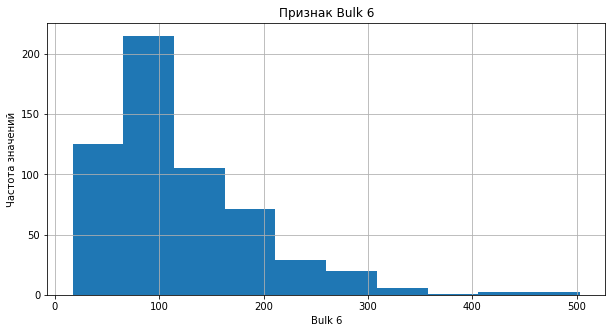

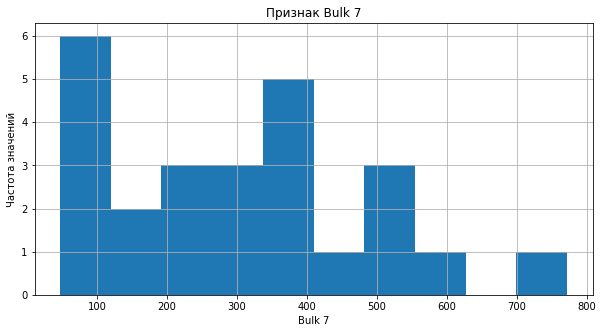

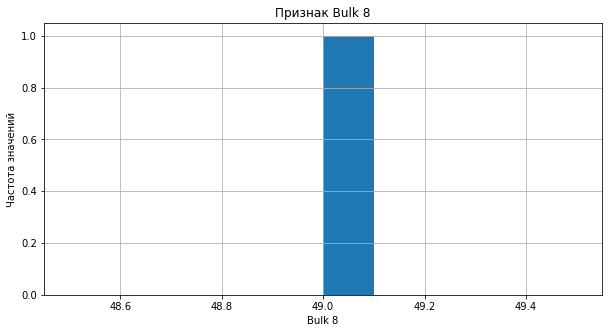

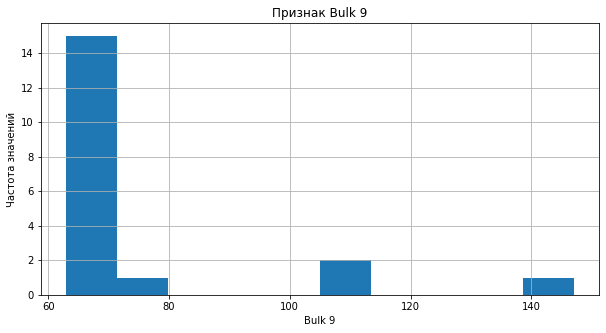

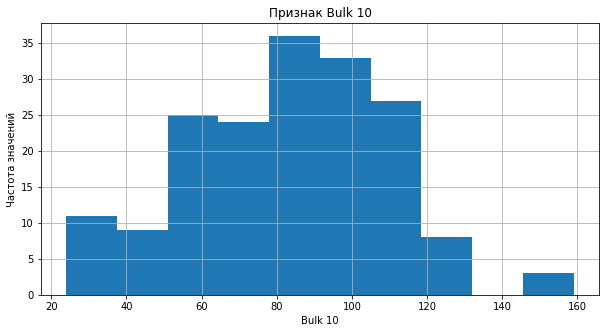

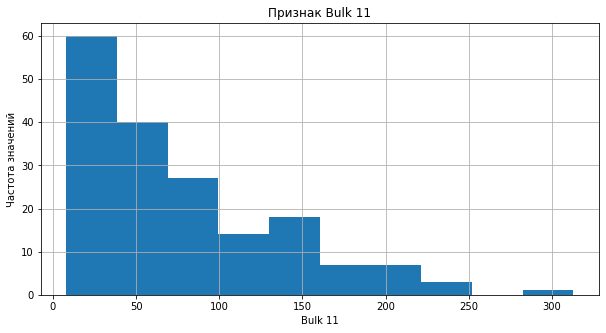

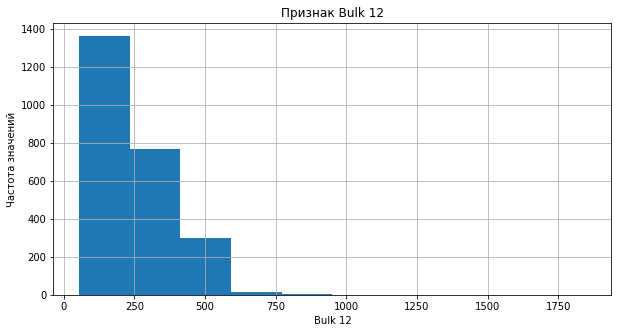

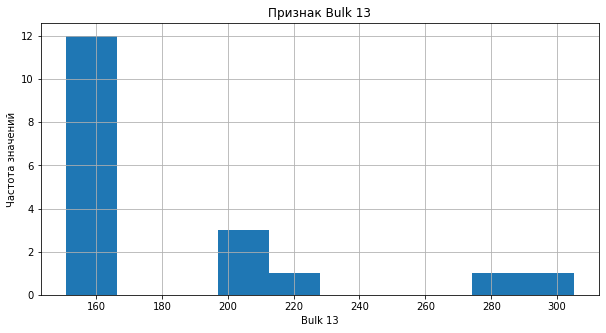

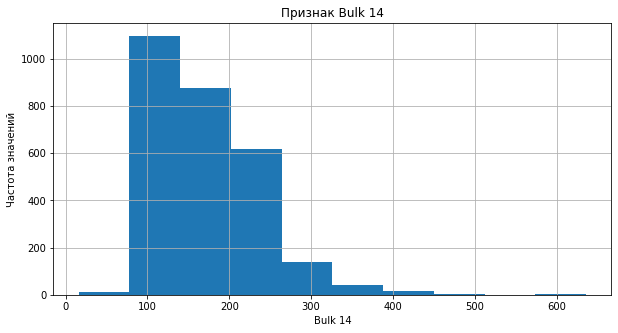

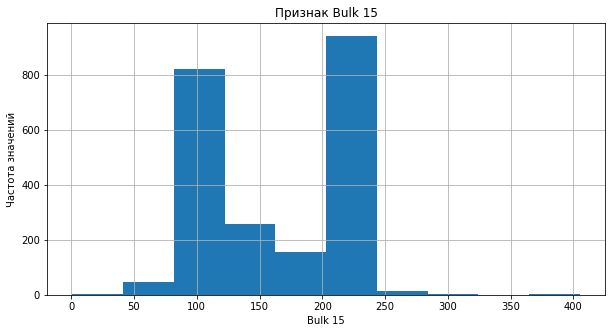

In [30]:
# определяем количественные признаки
numerical_features = [col for col in data_bulk_time_new.columns if col != 'key']

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(data_bulk_new[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show() 

Выше было дано пояснение по поводу заполнения пропусков нулями, продублирую:
    
    Таблица с данными о подаче сыпучих материалов (объём) (data_bulk_new.csv) содержит нулевые значения. Предположим, что пропуски можно заменить нулями, вероятно, сыпучие материалы просто не добавлялись в указанный момент времени.
    
Я целенаправленно делаю это сейчас, а не до вычисления отклонений, чтобы не исказить данные.

In [31]:
data_bulk_new = data_bulk_new.fillna(0)
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Мы не будем агрегировать данные (чтобы физики нас не расстреляли :)), но проверим, что количество уникальных ключей в таблице совпадает с количеством строк (3129).

In [32]:
unique_key = len(data_bulk_new['key'].unique())
unique_key

3129

Всё совпало, переходим к следующей таблице.

### data_bulk_time_new.csv — данные о подаче сыпучих материалов (время)

In [33]:
print('Количество дубликатов:', data_bulk_time_new.duplicated().sum())

Количество дубликатов: 0


Заменим тип данных на datetime.

In [34]:
date_columns = [col for col in data_bulk_time_new.columns if col != 'key']
data_bulk_time_new[date_columns] = data_bulk_time_new[date_columns].apply(pd.to_datetime)
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


Проверим даты на "адекватность".

In [35]:
print('Минимальная дата:\n', data_bulk_time_new[date_columns].min())
print('\nМаксимальная дата начала нагрева:\n', data_bulk_time_new[date_columns].max())


Минимальная дата:
 Bulk 1    2019-05-03 17:42:46
Bulk 2    2019-05-07 15:39:35
Bulk 3    2019-05-03 20:40:25
Bulk 4    2019-05-03 11:28:48
Bulk 5    2019-05-07 15:19:17
Bulk 6    2019-05-03 19:09:15
Bulk 7    2019-05-07 18:11:01
Bulk 8    2019-07-08 17:14:53
Bulk 9    2019-05-14 11:57:58
Bulk 10   2019-05-06 07:54:02
Bulk 11   2019-05-05 23:43:24
Bulk 12   2019-05-03 11:24:31
Bulk 13   2019-05-05 02:10:21
Bulk 14   2019-05-03 11:14:50
Bulk 15   2019-05-03 11:10:43
dtype: datetime64[ns]

Максимальная дата начала нагрева:
 Bulk 1    2019-09-05 09:11:32
Bulk 2    2019-08-13 11:47:39
Bulk 3    2019-09-06 12:26:52
Bulk 4    2019-09-05 03:35:21
Bulk 5    2019-09-02 18:16:52
Bulk 6    2019-09-06 16:24:28
Bulk 7    2019-09-05 19:07:49
Bulk 8    2019-07-08 17:14:53
Bulk 9    2019-08-16 09:11:56
Bulk 10   2019-09-04 10:03:22
Bulk 11   2019-09-06 05:03:14
Bulk 12   2019-09-06 15:01:44
Bulk 13   2019-09-01 01:53:02
Bulk 14   2019-09-06 17:26:33
Bulk 15   2019-09-06 17:23:15
dtype: datetime64[ns]


Все даты корректные - с мая по сентябрь 2019 года.

Выберем максимальное значение - позже нам важно, чтобы последнее добавление примеси или проволочных материалов по времени было не позже последнего измерения температуры (целевого признака).

In [36]:
data_bulk_time_new['Bulk_max'] = data_bulk_time_new[date_columns].max(axis=1)
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk_max
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,2019-05-03 11:28:48
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,2019-05-03 11:53:30
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,2019-05-03 12:32:39
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,2019-05-03 12:58:00
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,2019-05-03 13:34:12


### data_gas_new.csv — данные о продувке сплава газом

In [37]:
print('Количество дубликатов:', data_gas_new.duplicated().sum())

Количество дубликатов: 0


Проанализируем данные в таблице на наличие аномальных значений.
Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [38]:
info_data_gas_new = data_gas_new.describe().T
info_data_gas_new['norm_min']=info_data_gas_new['25%']-1.5*info_data_gas_new['std']
info_data_gas_new['norm_max']=info_data_gas_new['75%']+1.5*info_data_gas_new['std']
info_data_gas_new

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000,-590.579501,3834.579501
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504,-2.287402,23.100406


Визуализируем данные.

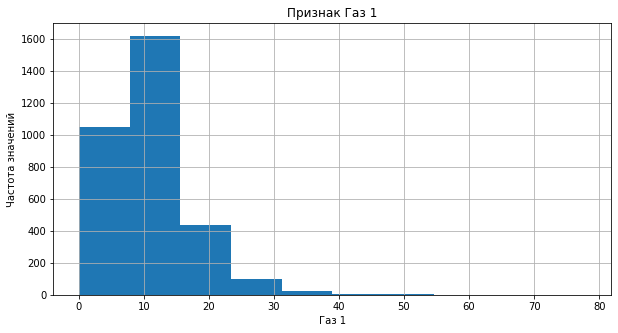

In [39]:
# определяем количественные признаки
numerical_features = ['Газ 1']

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(data_gas_new[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show()  

Возможно, максимальное значение (77.99504) выбивается из общей картины, но, считаю, у нас нет оснований признать его аномальным.

### data_temp_new.csv — результаты измерения температуры

In [40]:
#возможно, бесполезная штука, но привычка есть привычка :)
print('Количество дубликатов:', data_temp_new.duplicated().sum())

Количество дубликатов: 0


Заменим тип данных на datetime.

In [41]:
data_temp_new['Время замера'] = data_temp_new['Время замера'].apply(pd.to_datetime)
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Проанализируем данные в таблице на наличие аномальных значений. Построим графики для количественного признака - температура. Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [42]:
info_data_temp_new = data_temp_new.describe().T
info_data_temp_new['norm_min']=info_data_temp_new['25%']-1.5*info_data_temp_new['std']
info_data_temp_new['norm_max']=info_data_temp_new['75%']+1.5*info_data_temp_new['std']
info_data_temp_new

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0,-594.212077,3830.962077
Температура,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0,1549.408429,1629.591571


Видим анамально низкое значение температуры, визуализируем данные.

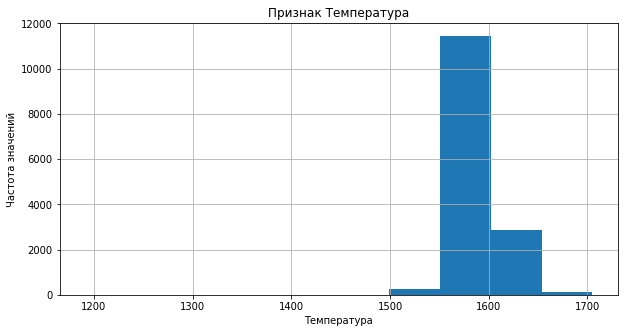

In [43]:
# определяем количественные признаки
numerical_features = ['Температура']

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(data_temp_new[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show()  

In [44]:
unique_values = sorted(data_temp_new['Температура'].unique())
print('Значения столбца "Температура":', unique_values[:10], '...', unique_values[-3:])

Значения столбца "Температура": [1191.0, 1204.0, 1208.0, 1218.0, 1227.0, 1515.0, 1519.0, 1520.0, 1521.0, 1522.0] ... [1704.0, 1705.0, nan]


Значения ниже 1400 градусов будем считать аномальными, выведем строки с такими значениями.

In [45]:
data_temp_new[(data_temp_new['Температура'] < 1400)]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Посмотрим на данные по каждому полученному ключу.

In [46]:
data_temp_new[data_temp_new['key'] == 867]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0


In [47]:
data_temp_new[data_temp_new['key'] == 1214]

,key,Время замера,Температура
6784,1214,2019-06-18 08:01:03,1208.0
6785,1214,2019-06-18 08:17:56,1608.0
6786,1214,2019-06-18 08:31:10,1608.0
6787,1214,2019-06-18 08:43:56,1591.0


In [48]:
data_temp_new[data_temp_new['key'] == 1619]

,key,Время замера,Температура
9050,1619,2019-07-03 02:34:41,1218.0
9051,1619,2019-07-03 02:39:29,1623.0
9052,1619,2019-07-03 02:43:59,1590.0


In [49]:
data_temp_new[data_temp_new['key'] == 2052]

,key,Время замера,Температура
11495,2052,2019-07-25 08:49:15,1227.0
11496,2052,2019-07-25 08:54:39,1592.0
11497,2052,2019-07-25 09:03:59,1590.0
11498,2052,2019-07-25 09:07:19,1591.0
11499,2052,2019-07-25 09:20:11,1515.0
11500,2052,2019-07-25 09:27:03,1592.0


In [50]:
data_temp_new[data_temp_new['key'] == 2561]

,key,Время замера,Температура
14283,2561,2019-08-12 18:49:29,1204.0
14284,2561,2019-08-12 18:59:23,NaN
14285,2561,2019-08-12 19:06:26,NaN
14286,2561,2019-08-12 19:11:13,NaN
14287,2561,2019-08-12 19:17:08,NaN
14288,2561,2019-08-12 19:21:45,NaN


In [51]:
# Оставляем только строки, где температура > 1400
data_temp_new = data_temp_new[data_temp_new['Температура'] > 1400]

unique_values = sorted(data_temp_new['Температура'].unique())
print('Значения столбца "Температура":', unique_values[:3], '...', unique_values[-3:])

Значения столбца "Температура": [1515.0, 1519.0, 1520.0] ... [1700.0, 1704.0, 1705.0]


Проверим даты на "адекватность".

In [52]:
print('Минимальная дата замера:', data_temp_new['Время замера'].min())
print('Максимальная дата замера:', data_temp_new['Время замера'].max())

Минимальная дата замера: 2019-05-03 11:02:04
Максимальная дата замера: 2019-09-06 16:48:55


Даты корректные - с мая по сентябрь 2019 года.

При удалении аномальных значений у нас удалились и нулевые значения (в сумме более 3,5 тысяч строк).

Если были удалены строки с начальным значением - ок, так как это важныей параметр для обучения, без него нет смысла оставлять строку для обучения.

Если были удалены строки с конечной температурой - ок, без целевого признака тоже нет смысла оценивать модель.

А промежуточные значения температуры нам не нужны.

Агрегируем данные по ключу, оставив минимальное и максимальное значения температуры.

In [53]:
# создаем таблицу с минимальным временем и соответствующей температурой для каждого ключа
min_table = data_temp_new.loc[data_temp_new.groupby('key')['Время замера'].idxmin(), ['key', 'Время замера', 'Температура']]

# создаем таблицу с максимальным временем и соответствующей температурой для каждого ключа
max_table = data_temp_new.loc[data_temp_new.groupby('key')['Время замера'].idxmax(), ['key', 'Время замера', 'Температура']]

# переименовываем столбцы для ясности
min_table = min_table.rename(columns={
    'Время замера': 'Минимальное время замера',
    'Температура': 'Температура при минимальном времени'
})

max_table = max_table.rename(columns={
    'Время замера': 'Максимальное время замера',
    'Температура': 'Температура при максимальном времени'
})

# объединяем таблицы по ключу
data_temp_new_agg = pd.merge(min_table, max_table, on='key', how='outer')

data_temp_new_agg

,key,Минимальное время замера,Температура при минимальном времени,Максимальное время замера,Температура при максимальном времени
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
3210,3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:31:15,1569.0
3211,3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:16:15,1584.0
3212,3239,2019-09-06 14:16:50,1598.0,2019-09-06 14:16:50,1598.0
3213,3240,2019-09-06 15:25:21,1617.0,2019-09-06 15:25:21,1617.0


###  data_wire_new.csv — данные о проволочных материалах (объём)

In [54]:
print('Количество дубликатов:', data_wire_new.duplicated().sum())

Количество дубликатов: 0


Проанализируем данные в таблице на наличие аномальных значений. Построим графики для каждого количественные признака. Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [55]:
info_data_wire_new = data_wire_new.describe().T
info_data_wire_new['norm_min']=info_data_wire_new['25%']-1.5*info_data_wire_new['std']
info_data_wire_new['norm_max']=info_data_wire_new['75%']+1.5*info_data_wire_new['std']
info_data_wire_new

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000,-576.495089,3833.495089
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424,9.096907,189.079261
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152,-38.786644,129.207882
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668,-54.135121,425.522180
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044,-2.429998,119.361619
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000,NaN,NaN
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575,-25.826167,115.092490
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674,-6.153120,24.801933
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401,20.772288,73.412194
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604,-7.839023,73.759427


Максимальные/минимальные значения показателей где-то выше/ниже рассчитанных, но не будем считать их аномальными, это же примеси, их значения, действительно, могут быть настолько разнородными.

Визуализируем данные.

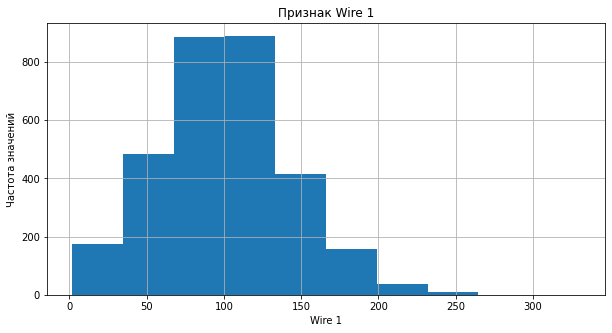

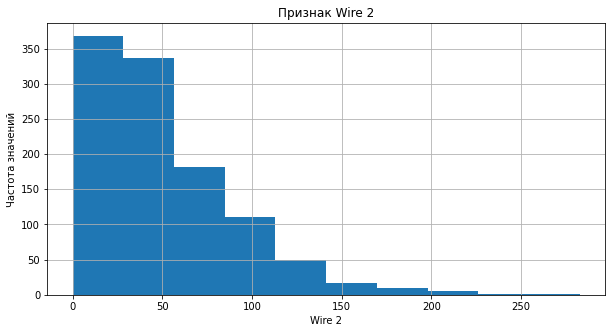

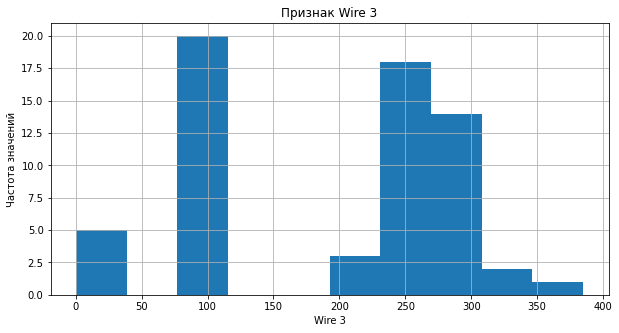

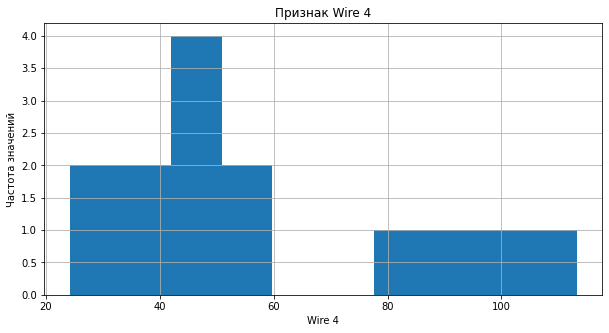

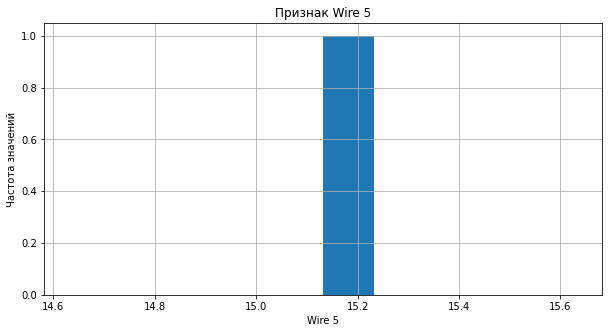

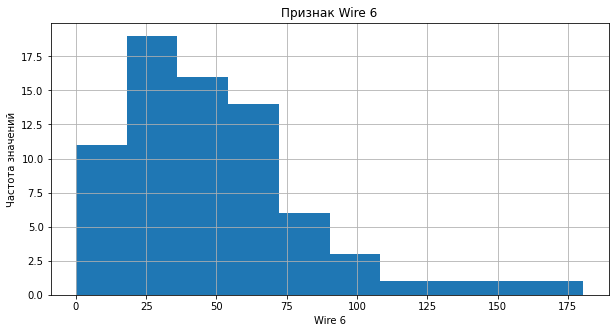

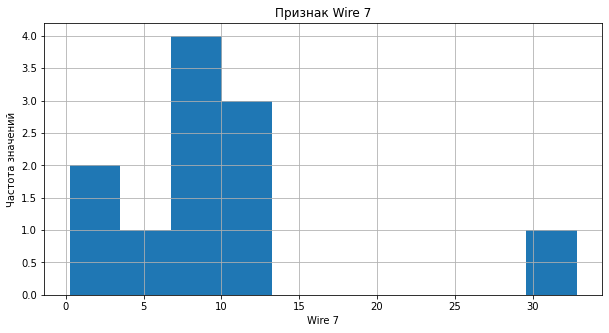

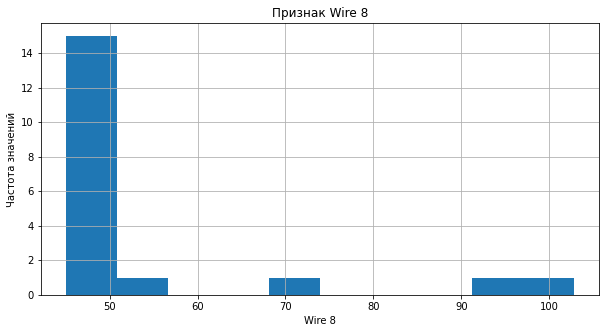

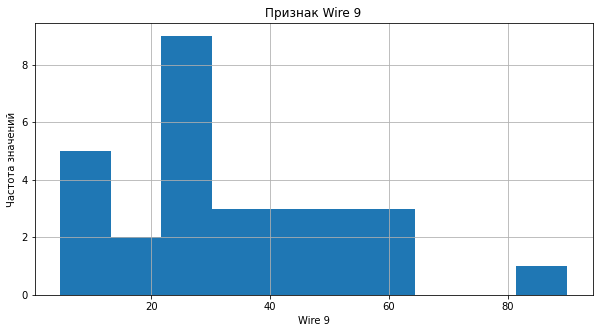

In [56]:
# определяем количественные признаки
numerical_features = [col for col in data_wire_new.columns if col != 'key']

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(data_wire_new[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show() 

Выше было дано пояснение по поводу заполнения пропусков нулями, продублирую:
    
    С данными о проволочных материалах (объём) (data_wire_new.csv) аналогично сыпучим материалам - пропуски можно заменить нулями.
    
Я целенаправленно делаю это сейчас, а не до вычисления отклонений, чтобы не исказить данные.

In [57]:
data_wire_new = data_wire_new.fillna(0)
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Мы не будем агрегировать данные, но проверим, что количество уникальных ключей в таблице совпадает с количеством строк (3081).

In [58]:
unique_key = len(data_wire_new['key'].unique())
unique_key

3081

Всё совпало, переходим к последней таблице.

### data_wire_time_new.csv — данные о проволочных материалах (время)

In [59]:
print('Количество дубликатов:', data_wire_time_new.duplicated().sum())

Количество дубликатов: 0


Заменим тип данных на datetime.

In [60]:
date_columns = [col for col in data_wire_time_new.columns if col != 'key']
data_wire_time_new[date_columns] = data_wire_time_new[date_columns].apply(pd.to_datetime)
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Проверим даты на "адекватность".

In [61]:
print('Минимальная дата:\n', data_wire_time_new[date_columns].min())
print('\nМаксимальная дата начала нагрева:\n', data_wire_time_new[date_columns].max())


Минимальная дата:
 Wire 1   2019-05-03 11:06:19
Wire 2   2019-05-03 13:15:34
Wire 3   2019-05-04 04:34:27
Wire 4   2019-05-07 15:19:17
Wire 5   2019-08-13 06:14:30
Wire 6   2019-05-07 14:46:05
Wire 7   2019-07-27 05:49:05
Wire 8   2019-05-14 11:29:24
Wire 9   2019-05-04 17:21:27
dtype: datetime64[ns]

Максимальная дата начала нагрева:
 Wire 1   2019-09-06 17:10:06
Wire 2   2019-09-06 07:35:40
Wire 3   2019-09-02 07:14:44
Wire 4   2019-08-13 03:16:45
Wire 5   2019-08-13 06:14:30
Wire 6   2019-08-18 19:10:56
Wire 7   2019-08-13 10:25:22
Wire 8   2019-08-16 08:56:23
Wire 9   2019-09-03 12:55:23
dtype: datetime64[ns]


Все даты корректные - с мая по сентябрь 2019 года.

Выберем максимальное значение - позже нам важно, чтобы последнее добавление примеси или проволочных материалов по времени было не позже последнего измерения температуры (целевого признака).

In [62]:
data_wire_time_new['Wire_max'] = data_wire_time_new[date_columns].max(axis=1)
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire_max
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:06:19
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:36:50
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:11:46
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:43:22
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:20:44


### Промежуточный вывод

На данном этапе работ мы выполнили подробный анализ данных, обработали пропуски, удалили аномальные значения, привели типы данных в соответствие, проверили данные на наличие дубликатов, а также агрегировали данные для последующего объединения в итоговую таблицу.

Заметка: на будущее надо предусмотреть изменение типа данных дат при чтении файла.

## Объединение данных

Объединим данные в итоговую таблицу по ключу (key):
 - из таблицы data_arc_new_agg возьмем столбцы 'Начало нагрева дугой', 'Полная мощность', 'Продолжительность нагрева (мин)' - то есть всю таблицу data_arc_new_agg;
 - из таблицы data_bulk_new возьмем столбцы возьмем все столбцы 'Bulk 1', 'Bulk 2' и т.д. (то есть всю таблицу data_bulk_new)
 - из таблицы data_bulk_time_new возьмем столбец 'Bulk_max'
 - из таблицы data_gas_new возьмем столбец 'Газ 1' (то есть всю таблицу data_gas_new)
 - из таблицы data_temp_new_agg возьмем столбцы 'Минимальное время замера', 'Температура при минимальном времени', 'Максимальное время замера', 'Температура при максимальном времени' (то есть всю таблицу data_temp_new_agg)
 - из таблицы data_wire_new возьмем все столбцы 'Wire 1', 'Wire 2' и т.д. (то есть всю таблицу data_wire_new)
 - из таблицы data_wire_time_new возьмем столбец 'Wire_max'

In [63]:
# чтобы ничего не пропустить, выполняем поэтапно
# сначала укажем how='outer', а потом удалим лишние строки (так ничего не потеряем)

# начинаем с data_arc_new_agg
final_table = data_arc_new_agg.copy()

# добавляем из data_bulk_new все столбцы
final_table = final_table.merge(data_bulk_new, on='key', how='inner')

# добавляем из data_bulk_time_new столбец 'Bulk_max'
final_table = final_table.merge(data_bulk_time_new[['key', 'Bulk_max']], on='key', how='inner')

# добавляем из data_gas_new все столбцы
final_table = final_table.merge(data_gas_new, on='key', how='inner')

# добавляем из data_temp_new_agg все столбцы
final_table = final_table.merge(data_temp_new_agg, on='key', how='inner')

# добавляем из data_wire_new все столбцы
final_table = final_table.merge(data_wire_new, on='key', how='inner')

# добавляем из data_wire_time_new столбец 'Wire_max'
final_table = final_table.merge(data_wire_time_new[['key', 'Wire_max']], on='key', how='inner')

Отберем данные по следующим критериям (о них говорили выше при анализе данных):
 - столбец "Начало нагрева дугой" больше столбца "Минимальное время замера"
 - "Максимальное время замера" больше "Bulk_max" и больше "Wire_max"	
 - "Максимальное время замера" и "Минимальное время замера" не пустое

In [64]:
final_table = final_table.dropna(subset=['Максимальное время замера'])
final_table = final_table.dropna(subset=['Минимальное время замера'])
final_table = final_table.dropna(subset=['Газ 1'])

final_table_filtered = final_table[
    (final_table['Начало нагрева дугой'] > final_table['Минимальное время замера']) &
    (final_table['Максимальное время замера'] > final_table['Bulk_max']) &
    (final_table['Максимальное время замера'] > final_table['Wire_max'])
]

final_table_filtered.head()

,key,Начало нагрева дугой,Полная мощность,Продолжительность нагрева (мин),Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk_max,Газ 1,Минимальное время замера,Температура при минимальном времени,Максимальное время замера,Температура при максимальном времени,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire_max
0,1,2019-05-03 11:02:14,3.718736,18.300000,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,2019-05-03 11:28:48,29.749986,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:06:19
1,2,2019-05-03 11:34:14,2.588349,13.516667,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,2019-05-03 11:53:30,12.555561,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:36:50
2,3,2019-05-03 12:06:54,5.019223,10.916667,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,2019-05-03 12:32:39,28.554793,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:11:46
3,4,2019-05-03 12:39:37,3.400038,12.350000,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,2019-05-03 12:58:00,18.841219,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:43:22
4,5,2019-05-03 13:11:13,2.816980,14.483333,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,2019-05-03 13:34:12,5.413692,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:20:44


Уберем временные отсечки, они нам не нужны для обучения модели.

In [65]:
final_table_filtered = final_table_filtered.drop(
    columns=['Начало нагрева дугой', 'Минимальное время замера', 'Максимальное время замера', 'Bulk_max', 'Wire_max']
)
final_table_filtered

,key,Полная мощность,Продолжительность нагрева (мин),Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Температура при минимальном времени,Температура при максимальном времени,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,3.718736,18.300000,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2.588349,13.516667,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5.019223,10.916667,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3.400038,12.350000,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2.816980,14.483333,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,3.868721,12.050000,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,1570.0,1591.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2496,5.070316,15.666667,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,1554.0,1591.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2497,4.360918,9.483333,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,1571.0,1589.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,2498,3.909917,12.500000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,1591.0,1594.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
final_table_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   key                                   2325 non-null   int64  
 1   Полная мощность                       2325 non-null   float64
 2   Продолжительность нагрева (мин)       2325 non-null   float64
 3   Bulk 1                                2325 non-null   float64
 4   Bulk 2                                2325 non-null   float64
 5   Bulk 3                                2325 non-null   float64
 6   Bulk 4                                2325 non-null   float64
 7   Bulk 5                                2325 non-null   float64
 8   Bulk 6                                2325 non-null   float64
 9   Bulk 7                                2325 non-null   float64
 10  Bulk 8                                2325 non-null   float64
 11  Bulk 9           

### Промежуточный вывод

В данном разделе мы создали сводную таблицу с данными для обучения.
На следующем этапе проведем анализ полученных данных и проверим, все ли признаки будут использованы для обучения.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Проведем анализ полученных признаков.
Пустых значений нет.
Как обычно, проверим на наличие дубликатов и число уникальных значений поля key.

In [67]:
print('Количество дубликатов:', final_table_filtered.duplicated().sum())

Количество дубликатов: 0


In [68]:
unique_key = len(final_table_filtered['key'].unique())
unique_key

2325

Все ключи уникальны, дубликатов нет.

Визуализируем данные.

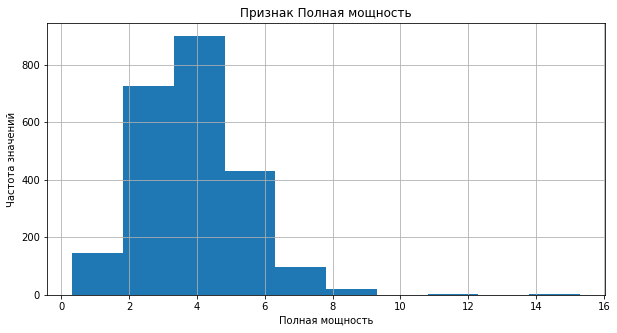

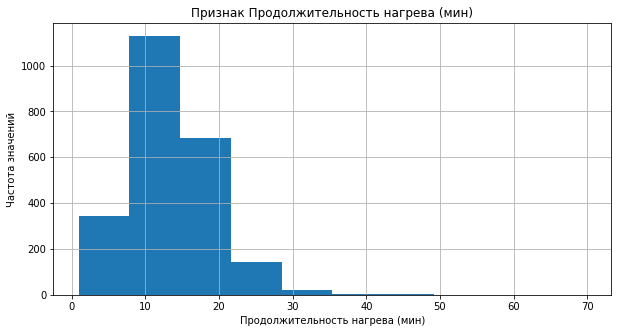

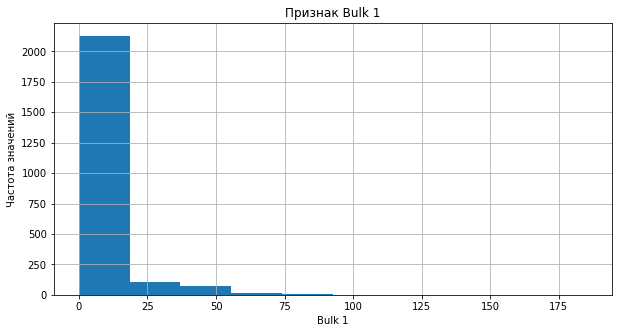

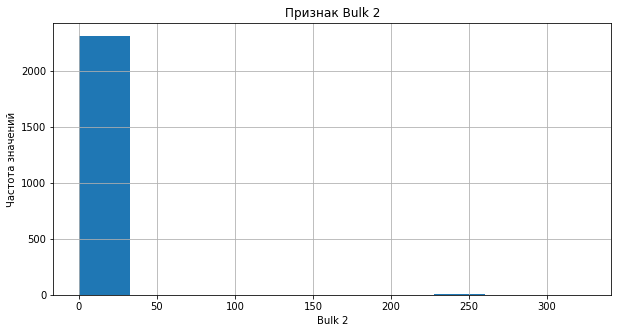

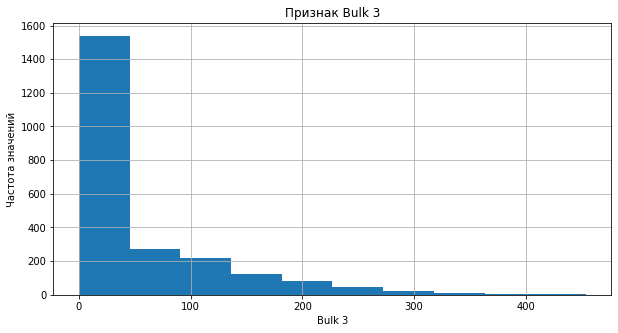

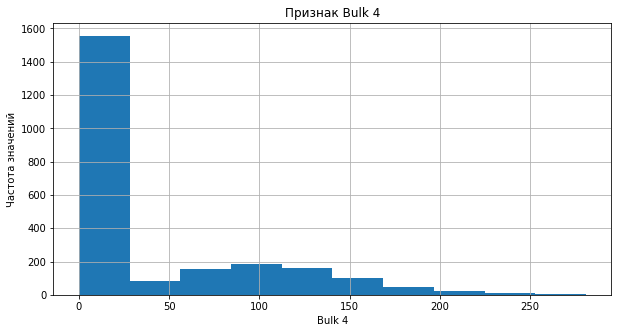

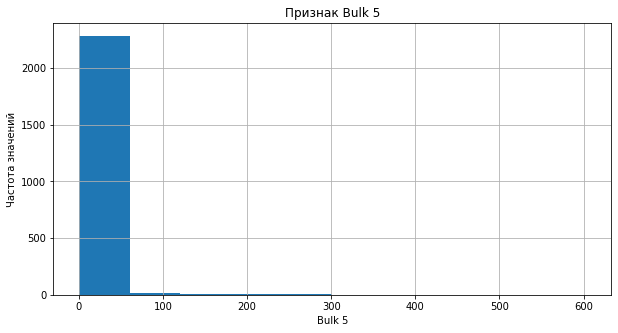

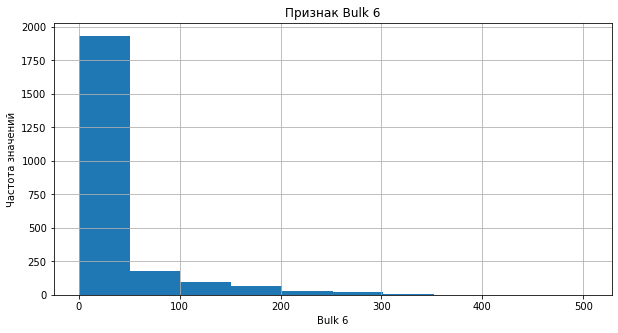

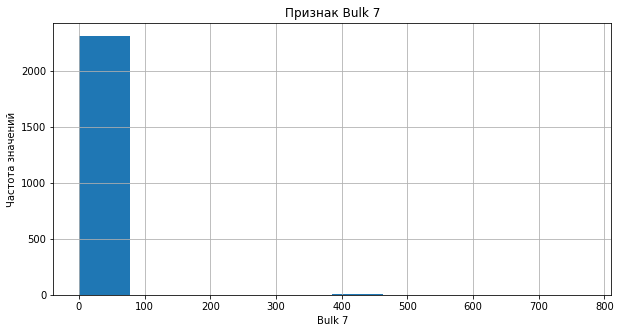

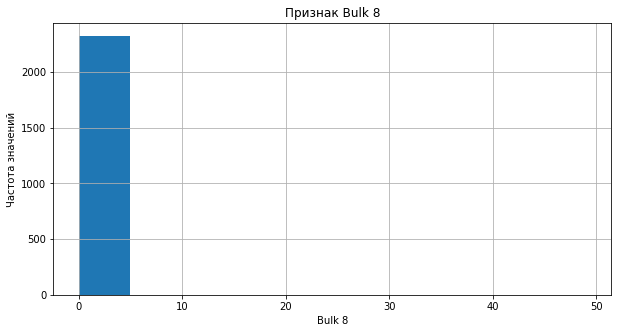

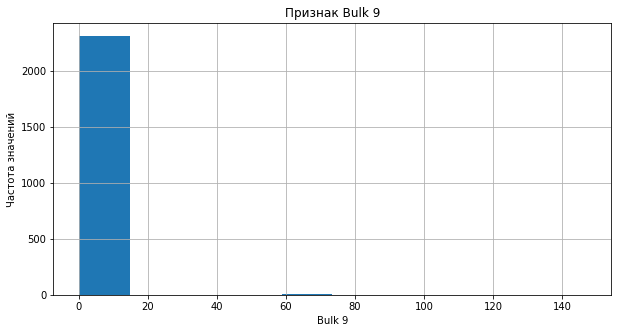

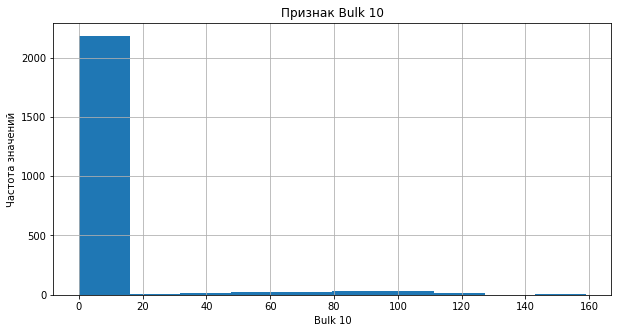

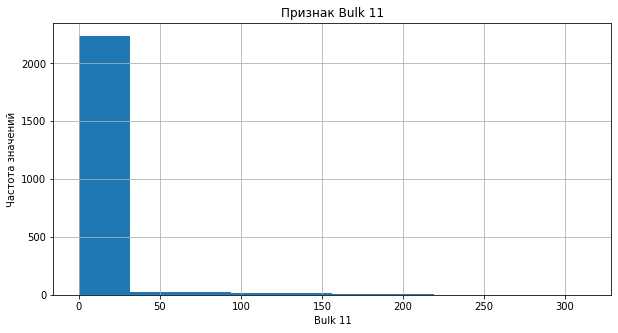

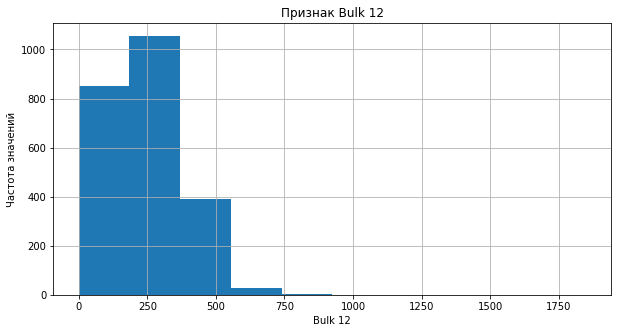

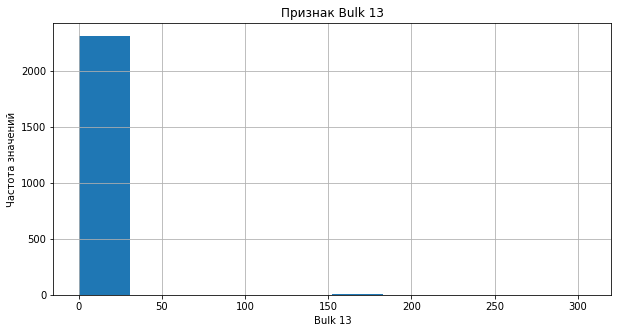

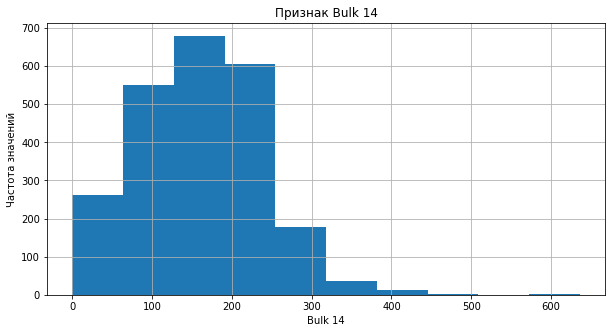

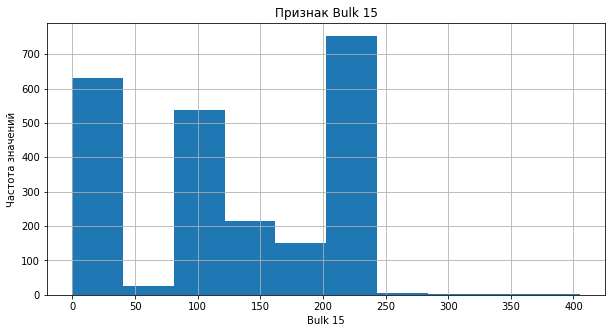

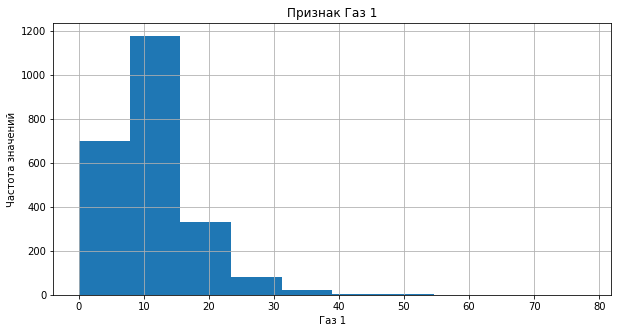

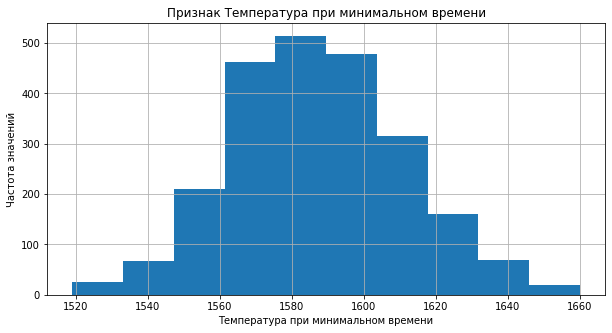

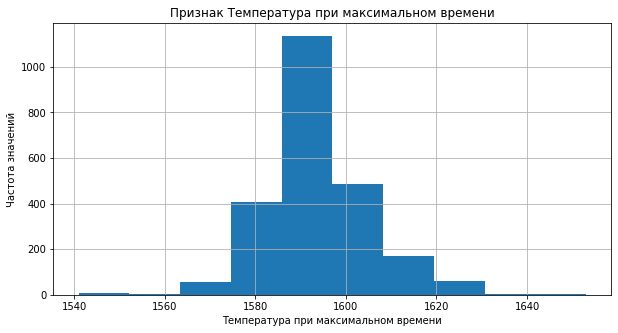

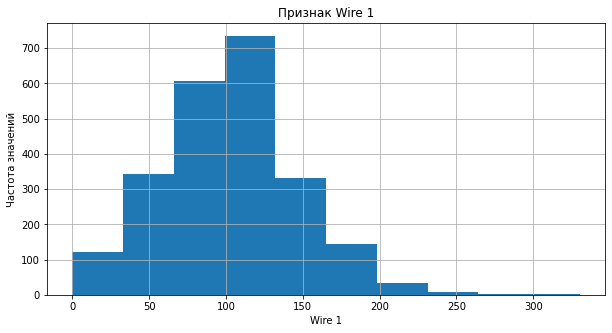

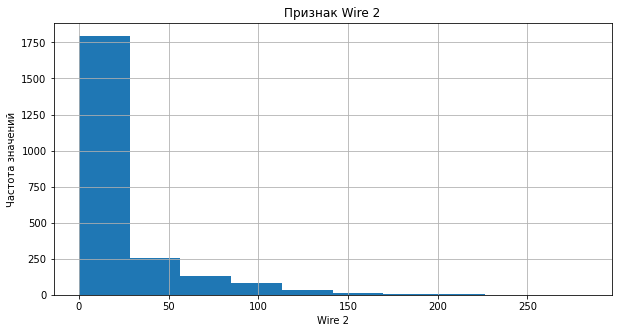

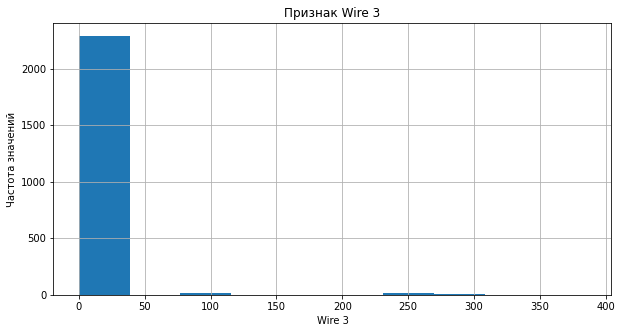

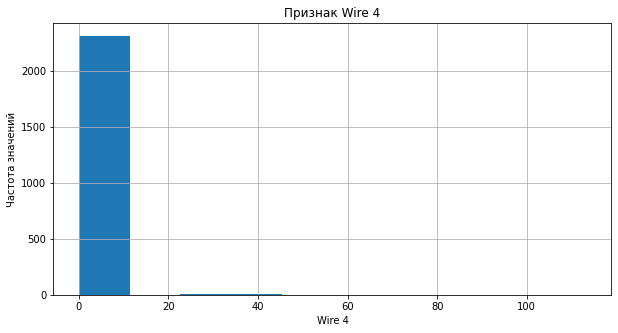

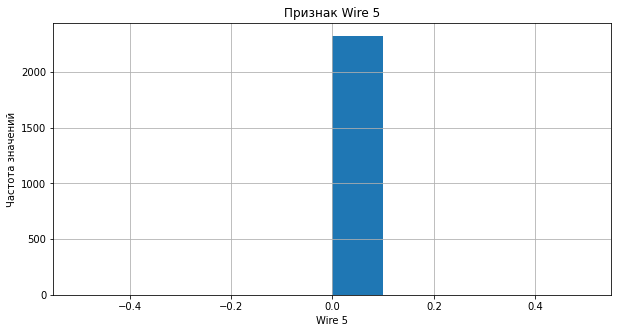

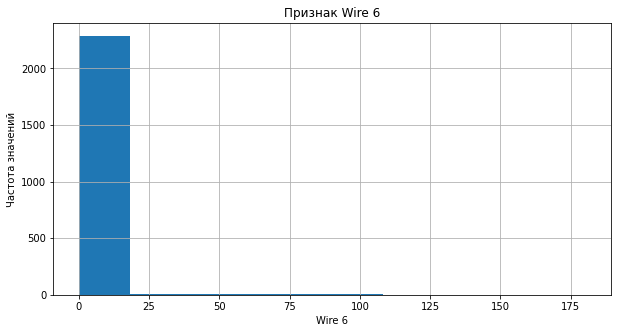

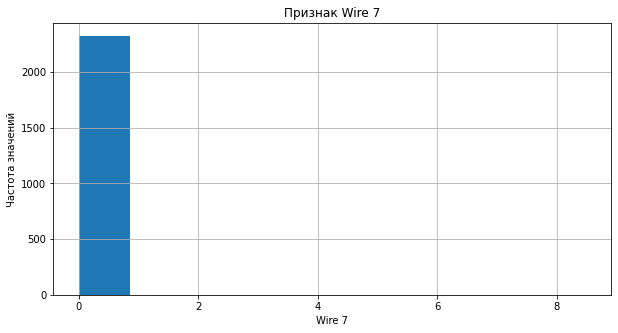

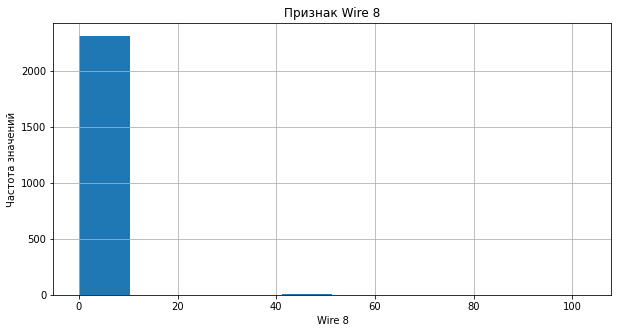

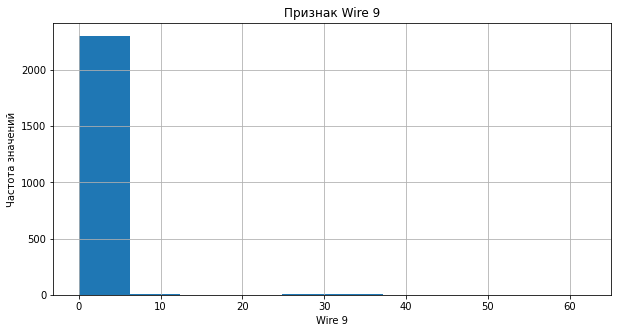

In [69]:
# определяем количественные признаки
numerical_features = [col for col in final_table_filtered.columns if col != 'key']

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(final_table_filtered[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show() 

Принимаем тот факт, что объем добавок непредсказуем, аномальных значений нет.

Проверим мультиколлинеарность признаков.

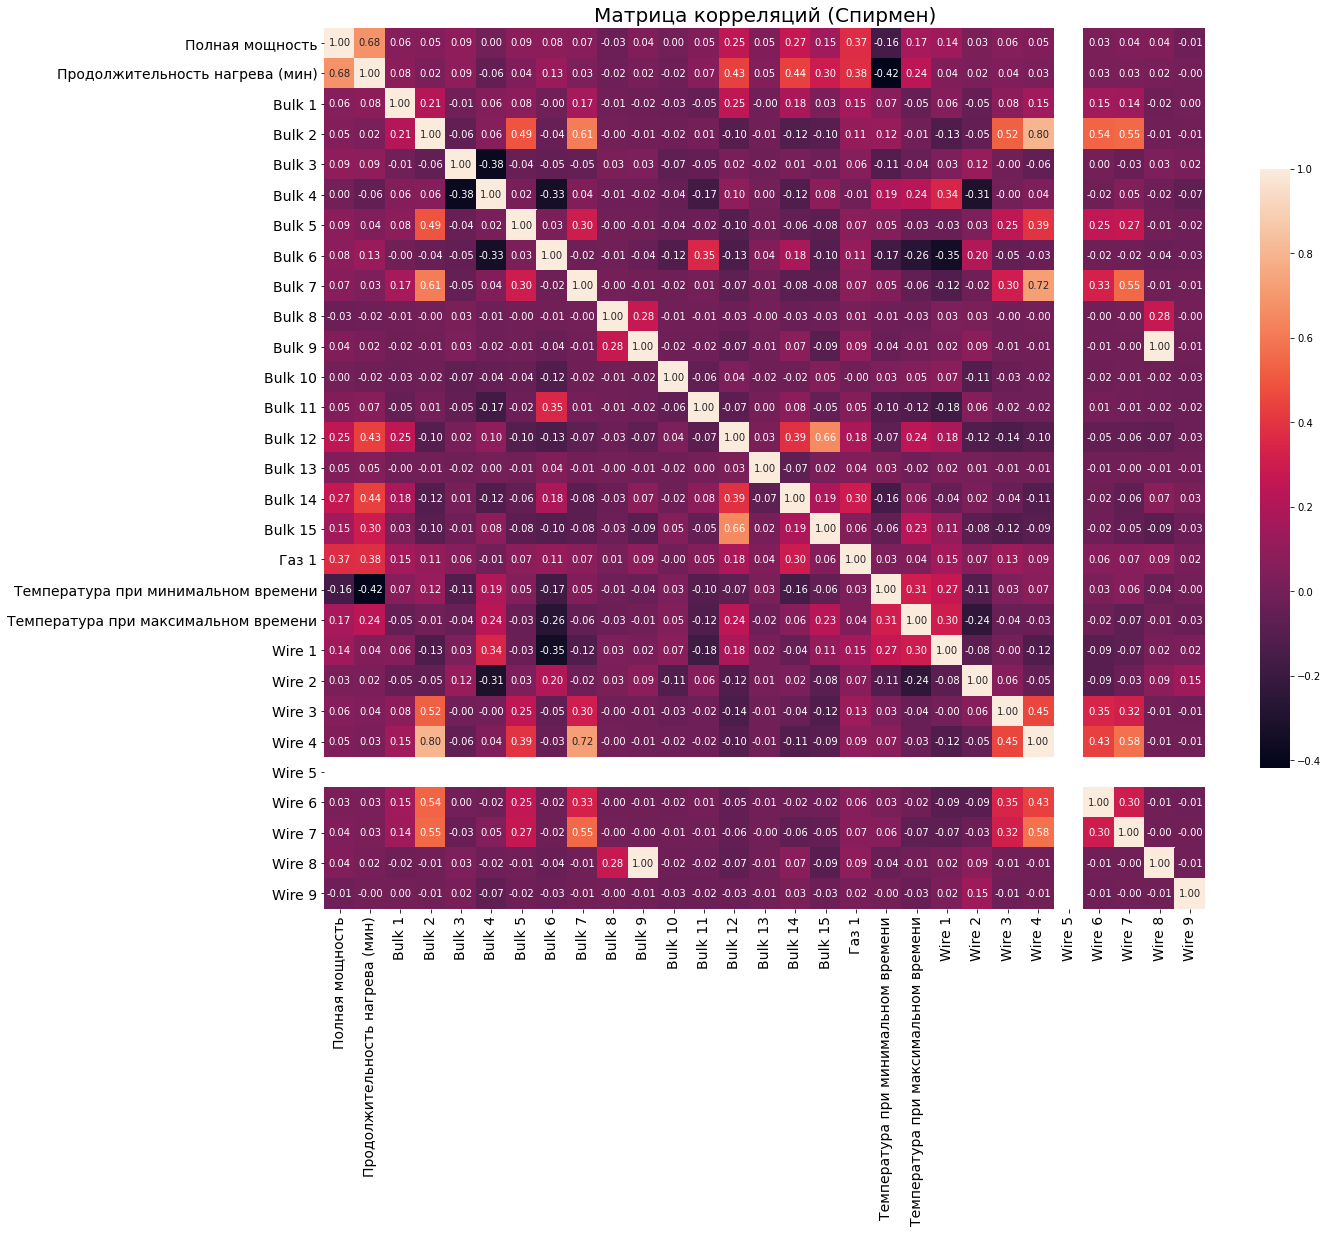

In [70]:
numerical_features = [col for col in final_table_filtered.columns if col != 'key']
corr_matrix = final_table_filtered[numerical_features].corr(method='spearman')

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    square=True,
    cbar_kws={'shrink': .5}
)
plt.title('Матрица корреляций (Спирмен)', fontsize=20)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Обычно нам неинтересны признаки:

    1. у которых корреляция с целевым признаком меньше 0.05
    2. у которых корреляция между собой больше 0.95 (исключая целевой признак)

Выведем эти признаки.

In [71]:
# список признаков без 'key' и целевой переменной
feature_cols = [col for col in final_table_filtered.columns if col not in ['key', 'Температура при максимальном времени']]

# корреляция каждого признака с целевой переменной (Спирмен)
corr_with_target = final_table_filtered[feature_cols].apply(
    lambda col: spearmanr(col, final_table_filtered['Температура при максимальном времени'])[0]
)

# признаки с низкой корреляцией
low_corr = corr_with_target[corr_with_target.abs() < 0.05].index.tolist()

# матрица корреляций между признаками (Спирмен)
features_corr = final_table_filtered[feature_cols].corr(method='spearman').abs()

# пары признаков с высокой корреляцией между собой
upper_mask = np.triu(np.ones(features_corr.shape), k=1).astype(bool)
high_corr_pairs = [
    (features_corr.index[i], features_corr.columns[j], features_corr.iloc[i, j])
    for i in range(len(features_corr))
    for j in range(len(features_corr))
    if upper_mask[i, j] and features_corr.iloc[i, j] > 0.95
]

print("Слабо коррелируют с целевым признаком:", low_corr)
print("Пары с высокой корреляцией между собой (>0.95):")
for f1, f2, val in high_corr_pairs:
    print(f"{f1} — {f2}: {val:.2f}")

Слабо коррелируют с целевым признаком: ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 5', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 13', 'Газ 1', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 8', 'Wire 9']
Пары с высокой корреляцией между собой (>0.95):
Bulk 9 — Wire 8: 1.00


/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


При изменении ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 5', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 13', 'Газ 1', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 8', 'Wire 9'] температура мало зависит, можем попробовать их удалить.
Связь Bulk 9 — Wire 8, всё равно осталась (эти признаки всё равно попали в список "слабо коррелируют с целевым признаком", так что тоже будут удалены).

In [72]:
# удаление признаков из таблицы
final_table_filtered = final_table_filtered.drop(columns=low_corr)
final_table_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2328
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   key                                   2325 non-null   int64  
 1   Полная мощность                       2325 non-null   float64
 2   Продолжительность нагрева (мин)       2325 non-null   float64
 3   Bulk 4                                2325 non-null   float64
 4   Bulk 6                                2325 non-null   float64
 5   Bulk 7                                2325 non-null   float64
 6   Bulk 11                               2325 non-null   float64
 7   Bulk 12                               2325 non-null   float64
 8   Bulk 14                               2325 non-null   float64
 9   Bulk 15                               2325 non-null   float64
 10  Температура при минимальном времени   2325 non-null   float64
 11  Температура при м

### Промежуточный вывод

На текущем этапе мы исследовали данные итоговой таблицы и оставили только необходимые для обучения признаки.

## Подготовка данных

Выполним подготовку данных для обучения модели. 
Разделим данные на две выборки, выполним масштабирование данных (кодировании не потребуется, так как 

In [73]:
# целевая переменная
target_col = 'Температура при максимальном времени'

# разделим датафрейм на входные признаки и целевую переменную
X = final_table_filtered.drop(columns=['key', target_col])
y = final_table_filtered[target_col]

# разделим датафрейм на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# масштабирование (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Промежуточный вывод
В этом разделе выполнили подготовку данных, переходим к обучению моделей.

## Обучение моделей машинного обучения

Обучим как минимум три модели (линейная регрессия, случайный лес, CatBoost). 
Выполните автоматизированный подбор гиперпараметров (по условию "хотя бы у одной модели", сделаем на двух). 
Выполним выбор лучшей модели по метрике на кросс-валидации и проверим качество лучшей модели на тестовой выборке.
Критерий MAE <=6.8.

Примечание: для линейной регрессии используем функцию cross_val_score (нецелесообразно использовать GridSearchCV или RandomizedSearchCV).

После обучения моделей оценим важность признаков.

In [74]:
# модель 1: линейная регрессия
linreg = LinearRegression()
linreg_scores = -cross_val_score(linreg, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE линейной регрессии (CV): {linreg_scores.mean():.2f}")

# модель 2: случайный лес + GridSearchCV 
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_
# rf_scores = -cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
# print(f"MAE случайного леса (CV): {rf_scores.mean():.2f}")
print(f"MAE случайного леса (CV): {-rf_grid.best_score_:.2f}")

# модель 3: CatBoost + GridSearchCV
cat = CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)
cat_param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1],
    'iterations': [300, 500],
}
cat_grid = GridSearchCV(cat, cat_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
cat_grid.fit(X_train, y_train)
best_cat = cat_grid.best_estimator_
# cat_scores = -cross_val_score(best_cat, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
# print(f"MAE CatBoost (CV): {cat_scores.mean():.2f}")
print(f"MAE CatBoost (CV): {-cat_grid.best_score_:.2f}")

# выбор лучшей модели по кросс-валидации
models_cv = {
    'LinearRegression': linreg_scores.mean(),
    # 'RandomForest': rf_scores.mean(),
    # 'CatBoost': cat_scores.mean()
    'RandomForest': -rf_grid.best_score_,
    'CatBoost': -cat_grid.best_score_
}
best_model_name = min(models_cv, key=models_cv.get)
print(f"\nЛучшая модель по кросс-валидации: {best_model_name}")

# Финальное обучение и предсказание — только для победившей модели
if best_model_name == 'LinearRegression':
    linreg.fit(X_train_scaled, y_train)
    y_pred = linreg.predict(X_test_scaled)
    final_model = linreg
    final_X_train, final_X_test = X_train_scaled, X_test_scaled
elif best_model_name == 'RandomForest':
    best_rf.fit(X_train_scaled, y_train)
    y_pred = best_rf.predict(X_test_scaled)
    final_model = best_rf
    final_X_train, final_X_test = X_train_scaled, X_test_scaled
elif best_model_name == 'CatBoost':
    best_cat.fit(X_train, y_train)
    y_pred = best_cat.predict(X_test)
    final_model = best_cat
    final_X_train, final_X_test = X_train, X_test

# MAE на тестовой выборке — только для финальной модели
test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE на тестовой выборке: {test_mae:.2f}")

MAE линейной регрессии (CV): 6.85
MAE случайного леса (CV): 6.39
MAE CatBoost (CV): 6.25

Лучшая модель по кросс-валидации: CatBoost
MAE на тестовой выборке: 6.01


Итак, лучшую модель получили, целевой показатель качества модели достигнут.

Оценим важность признаков.

Стоит отметить, что атрибут feature_importances_ есть, например, у RandomForest и CatBoost, но нет у линейной регрессии. Мы будем использовать два метода:

	•	feature_importances_ - показывает среднюю важность признаков, удобно для базового анализа.
	•	SHAP — даёт локальные объяснения (на уровне отдельных строк) + глобальную картину, более информативен, особенно при сложных зависимостях.

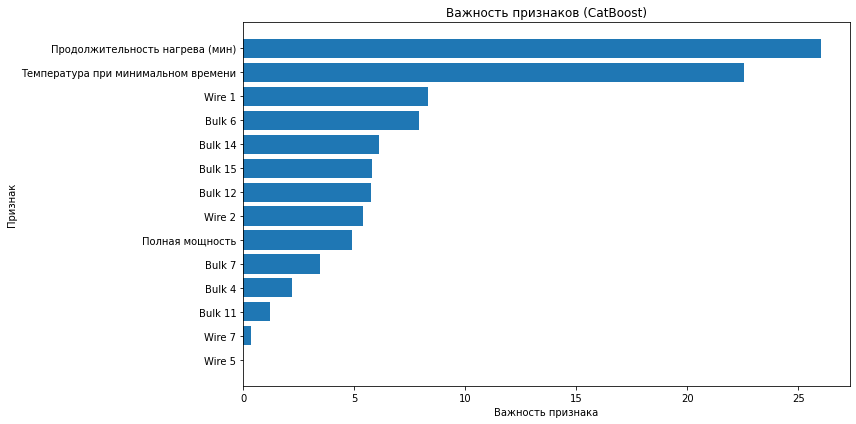

 96%|=================== | 556/582 [00:11<00:00]       

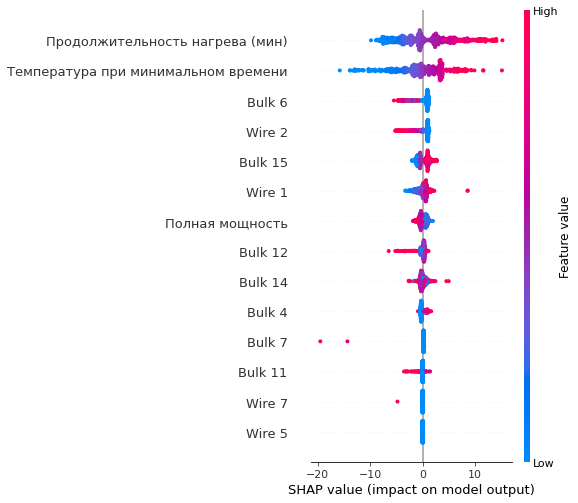

In [75]:
# важность признаков 
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feature_names = X.columns
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    plt.barh(importances_df['Feature'], importances_df['Importance'])
    plt.xlabel('Важность признака')
    plt.ylabel('Признак')
    plt.title(f'Важность признаков ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# SHAP-анализ
explainer = shap.Explainer(final_model, final_X_train)
shap_values = explainer(final_X_test)

shap.summary_plot(shap_values.values, features=final_X_test, feature_names=X.columns)


В целом, получился достаточно логичный вывод по важности критериев - важна первоначальная температура и продолжительность нагрева.
Полная мощность и ряд примесей также имеют влияние на целевой показатель, но не такое значительное (Wire 5 трудно проанализировать, там одно значение).

### Промежуточный вывод
На данном этапе мы обучили три модели и выбрали из них лучшую, а также провели анализ важности параметров.

## Итоговый вывод

Итак, подведем итоги.

В рамках текущего проекта нами была разработана модель предсказания температуры сплава на этапе обработки стали. Это решение может стать частью стратегии по снижению энергопотребления на металлургическом комбинате «Стальная птица». Модель успешно прошла все этапы: от подготовки и анализа данных до тестирования на реальных производственных данных. Целевая метрика MAE составила менее 6.8, что соответствует установленным требованиям.

**Что было сделано:**

1. В рамках нашего проекта на первом этапе была выполнена загрузка данных, их изучение и чистка от аномальных значений:
            - исправили отрицательное значение реактивной энергии,
            - удалили строки с начальной температурой меньше 1400 градусов.
Также агрегировали данные для последующего объединения в итоговую таблицу.

2. После объединения данных в итоговую таблицу, провели исследовательский анализ объединенных данных.
Выявили и удалили:
            - признаки, которые слабо коррелируют с целевым признаком: ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 5', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 13', 'Газ 1', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 8', 'Wire 9']
            - пары признаков с высокой корреляцией между собой (>0.95): Bulk 9 — Wire 8

3. Обучили три модели (линейная регрессия, случайный лес, CatBoost). Выполнили автоматизированный подбор гиперпараметров, выбрали лучшую модель (CatBoost) и проверили качество лучшей модели на тестовой выборке. Критерий MAE <=6.8.

4. После обучения моделей оценили важность признаков.
Вывод по важности критериев: важна первоначальная температура и продолжительность нагрева.



**Чтобы использовать модель максимально эффективно для достижения главной цели — снижения энергопотребления, мы предлагаем рассмотреть следующие направления:**

1. Управление ключевыми параметрами — начальная температура

Модель показала, что наибольшее влияние на итоговую температуру оказывает начальная температура и время нагрева. Это означает, что управляя этими параметрами, можно:
            - снизить итоговое энергопотребление;
            - добиться более стабильного качества продукции.

Предложение: провести технический аудит на предмет возможности управления начальной температурой и её стабилизации в допустимых пределах.

2. Смена постановки задачи — от предсказания к контролю разброса

На практике невозможно полностью избежать колебаний температуры — они связаны с множеством факторов (сырьё, условия нагрева, состав газа и т.д.).

Предложение: рассмотреть альтернативный подход — фокусироваться не на предсказании температуры, а на контроле и минимизации её отклонений от нормы.

Что можно сделать:
            - определить допустимые границы температуры.
            - ввести бинарную метку: “в пределах нормы” (0) и “выход за границы” (1).
            - построить модель, объясняющую причины выбросов.
            - анализировать, в каких условиях происходят отклонения: смена бригады, состав материала, сырьё, электрод, расход газа и т.д.
            - на основе этого — разрабатывать энергосберегающие мероприятия, нацеленные на уменьшение разброса и исключение выбросов.

3. Внедрение модели в производственный цикл

Предложение: использовать разработанную модель как инструмент оперативного контроля, который будет:
            - выдавать прогноз температуры по входным параметрам;
            - сравнивать его с фактом;
            - сигнализировать о вероятном выходе за рамки нормы;
            - сохранять информацию для последующего анализа и оптимизации.
Используя предложенный подход, возможно внедрить механизм раннего оповещения о потенциальных нарушениях температурного режима, что позволит оперативно реагировать и снижать энергозатраты.


Модель — это инструмент управления. Используя её в связке с анализом отклонений, можно не просто прогнозировать, но и влиять на производственный процесс (и, как следствие, снижать затраты).